In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
def tf_extractor(corpus):  
    # returns a frequency-based DTM
    vectorizer = CountVectorizer(min_df=1, ngram_range=(1,1)) 
    features = vectorizer.fit_transform(corpus) # transform texts to a frequency matrix
    return vectorizer, features

In [3]:
def tfidf_extractor(corpus):
    # returns a tf-idf based DTM
    vectorizer = TfidfVectorizer(min_df=1, 
                                 norm='l2',
                                 smooth_idf=True,
                                 use_idf=True,
                                 ngram_range=(1,1))
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

In [4]:
with open('NOUN_전체_TEXT.txt', 'r', encoding="utf-8") as f:
    total_docs = [x.strip().split(',') for x in f.readlines()]
    docs =  [(int(doc[3]), doc[4]) for doc in total_docs if len(doc) == 5 and doc[3]!="Vote_Count"]
    scores, texts = zip(*docs)

In [5]:
filtered_texts = []
filtered_labels = []

for score, text in zip(scores, texts):
    if 5 < score < 100:
        continue
        
    # 평점 기준으로 문서에 label을 부여
    # 0~100 -> 부정, 0
    # 1000~ -> 긍정, 1
    filtered_texts.append(text)
    filtered_labels.append(1 if score > 99 else 0)

In [6]:
num_reviews = len(filtered_texts) #788189

num_train = int(num_reviews*0.7) #551732
# 전체 리뷰 중에서 70%를 training data로 사용하고, 나머지 30%를 test data로 사용
train_texts = filtered_texts[:num_train]
train_labels = filtered_labels[:num_train]
test_texts = filtered_texts[num_train+1:]
test_labels = filtered_labels[num_train+1:]

In [7]:
# You can also use the following method
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_labels, test_labels = train_test_split(filtered_texts, filtered_labels, test_size=0.3, random_state=0)

In [8]:
tf_vectorizer, train_tf_features = tf_extractor(train_texts)
# input의 형태 = list of docs
test_tf_features = tf_vectorizer.transform(test_texts)
vocablist = [word for word, _ in sorted(tf_vectorizer.vocabulary_.items(), key=lambda x:x[1])]
# tf_vectorizer.vocabulary_.items() returns a list of (word, frequency)
# We sort words based on their frequencies and save the words

In [9]:
# tf matrix를 사용한 경우
lr = LogisticRegression(C=0.1, penalty='l2', solver='sag') # Lasso regression
# C = Inverse of regularization strength(==lamda), 즉 C 값이 작을수록 penalty를 많이 준다는 것입니다.
#C는 hyper parameter로, 학습을 통해 도출할 수 없음 / 사람이 지정해야함; 5가지 정도를 실행해보고 가장 정확한 결과를 도출하는 것을 활용
# penalty를 많이 준다는 뜻은 L1 같은 경우는 feature의 수를 그만큼 많이 줄인다는 뜻이고
# L2인 경우는 weight 값을 더 0에 가깝게 한다는 뜻입니다.
lr.fit(train_tf_features, train_labels) # 학습
pred_labels = lr.predict(test_tf_features)
print('Misclassified samples: {} out of {}'.format((pred_labels != test_labels).sum(),len(test_labels)))
print('Accuracy: %.2f' % accuracy_score(test_labels, pred_labels))

c:\programdata\miniconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Misclassified samples: 7573 out of 73337
Accuracy: 0.90


In [10]:
# tfidf matrix를 사용한 경우
tfidf_vectorizer, train_tfidf_features = tfidf_extractor(train_texts)
test_tfidf_features = tfidf_vectorizer.transform(test_texts)
lr = LogisticRegression(C=0.1, penalty='l1', solver='saga') # Lasso regression
lr.fit(train_tfidf_features, train_labels) # 학습
pred_labels = lr.predict(test_tfidf_features)
print('Misclassified samples: {} out of {}'.format((pred_labels != test_labels).sum(),len(test_labels)))
print('Accuracy: %.2f' % accuracy_score(test_labels, pred_labels))

Misclassified samples: 6540 out of 73337
Accuracy: 0.91


In [11]:
coefficients = lr.coef_.tolist()

sorted_coefficients = sorted(enumerate(coefficients[0]), key=lambda x:x[1], reverse=True)
# 학습에 사용된 각 단어마다의 coefficient (즉 weight) 값이 존재
# coefficient값이 큰 순으로 정렬 'reverse=True'

print(sorted_coefficients[:5])
# print top 50 positive words
for word, coef in sorted_coefficients[:50]:
    print('{0:} ({1:.3f})'.format(vocablist[word], coef))
# print top 50 negative words
for word, coef in sorted_coefficients[-50:]:
    print('{0:} ({1:.3f})'.format(vocablist[word], coef))
    
#기계학습 텍스트분석에서 각 단어는 하나의 변수; coefficient는 모델의 parameter에 해당된다; y = b1 + b0x에서 단어(tf or tfidf)는 x, coefficent는 b0임

[(14560, 6.58947139145413), (69620, 6.5584286824587785), (19978, 6.441285178259406), (19980, 5.521922322470052), (65703, 5.3164878263442805)]
난민 (6.589)
이재명 (6.558)
대한항공 (6.441)
대합 (5.522)
위배 (5.316)
난임 (4.950)
신도시 (4.822)
까지 (4.807)
전명규 (4.732)
대위 (4.677)
불구 (4.517)
물의 (4.461)
지난 (4.416)
방용훈 (3.981)
공매도 (3.960)
누진세 (3.948)
동물 (3.918)
조선일보 (3.882)
구합 (3.794)
조현민 (3.702)
간곡 (3.699)
폭행 (3.433)
교사 (3.299)
조합원 (3.295)
또한 (3.267)
유은혜 (3.191)
국회의원 (3.165)
저희 (3.152)
주민 (3.143)
사망 (3.099)
시오 (2.970)
사태 (2.950)
정형식 (2.902)
의원 (2.890)
진행 (2.887)
사건 (2.877)
대한 (2.858)
자매 (2.857)
의혹 (2.820)
학부모 (2.809)
간호사 (2.655)
철저 (2.626)
처벌 (2.599)
분노 (2.585)
강아지 (2.571)
철회 (2.571)
요청 (2.516)
조재현 (2.415)
이번 (2.414)
상황 (2.342)
신청 (-0.083)
지금 (-0.097)
정치 (-0.123)
소득 (-0.183)
나라 (-0.210)
사욕 (-0.219)
사리 (-0.260)
경제 (-0.318)
어요 (-0.320)
담배 (-0.345)
부동산 (-0.365)
청년 (-0.366)
주택 (-0.390)
선거 (-0.412)
단속 (-0.425)
수급 (-0.522)
사람 (-0.558)
취업 (-0.617)
미래 (-0.665)
공무원 (-0.680)
미국 (-0.719)
중소기업 (-0.751)
신고 (-0.760)
외상 (-0.7

In [12]:
positive=[]
negative=[]
for word, coef in sorted_coefficients[:50]:
    a = '{0:} ({1:.3f})'.format(vocablist[word], coef)
    positive.append(a)
# print top 50 negative words
for word, coef in sorted_coefficients[-50:]:
    b='{0:} ({1:.3f})'.format(vocablist[word], coef)
    negative.append(b)

In [13]:
positive_all = []
for i in range(len(positive)):
    c=positive[i].split(" ")
    positive_all.append(c)
positive_all

[['난민', '(6.589)'],
 ['이재명', '(6.558)'],
 ['대한항공', '(6.441)'],
 ['대합', '(5.522)'],
 ['위배', '(5.316)'],
 ['난임', '(4.950)'],
 ['신도시', '(4.822)'],
 ['까지', '(4.807)'],
 ['전명규', '(4.732)'],
 ['대위', '(4.677)'],
 ['불구', '(4.517)'],
 ['물의', '(4.461)'],
 ['지난', '(4.416)'],
 ['방용훈', '(3.981)'],
 ['공매도', '(3.960)'],
 ['누진세', '(3.948)'],
 ['동물', '(3.918)'],
 ['조선일보', '(3.882)'],
 ['구합', '(3.794)'],
 ['조현민', '(3.702)'],
 ['간곡', '(3.699)'],
 ['폭행', '(3.433)'],
 ['교사', '(3.299)'],
 ['조합원', '(3.295)'],
 ['또한', '(3.267)'],
 ['유은혜', '(3.191)'],
 ['국회의원', '(3.165)'],
 ['저희', '(3.152)'],
 ['주민', '(3.143)'],
 ['사망', '(3.099)'],
 ['시오', '(2.970)'],
 ['사태', '(2.950)'],
 ['정형식', '(2.902)'],
 ['의원', '(2.890)'],
 ['진행', '(2.887)'],
 ['사건', '(2.877)'],
 ['대한', '(2.858)'],
 ['자매', '(2.857)'],
 ['의혹', '(2.820)'],
 ['학부모', '(2.809)'],
 ['간호사', '(2.655)'],
 ['철저', '(2.626)'],
 ['처벌', '(2.599)'],
 ['분노', '(2.585)'],
 ['강아지', '(2.571)'],
 ['철회', '(2.571)'],
 ['요청', '(2.516)'],
 ['조재현', '(2.415)'],
 ['이번', '(2.414)'],


In [14]:
negative_all = []
for i in range(len(negative)):
    d=negative[i].split(" ")
    negative_all.append(d)
negative_all

[['신청', '(-0.083)'],
 ['지금', '(-0.097)'],
 ['정치', '(-0.123)'],
 ['소득', '(-0.183)'],
 ['나라', '(-0.210)'],
 ['사욕', '(-0.219)'],
 ['사리', '(-0.260)'],
 ['경제', '(-0.318)'],
 ['어요', '(-0.320)'],
 ['담배', '(-0.345)'],
 ['부동산', '(-0.365)'],
 ['청년', '(-0.366)'],
 ['주택', '(-0.390)'],
 ['선거', '(-0.412)'],
 ['단속', '(-0.425)'],
 ['수급', '(-0.522)'],
 ['사람', '(-0.558)'],
 ['취업', '(-0.617)'],
 ['미래', '(-0.665)'],
 ['공무원', '(-0.680)'],
 ['미국', '(-0.719)'],
 ['중소기업', '(-0.751)'],
 ['신고', '(-0.760)'],
 ['외상', '(-0.781)'],
 ['방법', '(-0.799)'],
 ['대통령', '(-0.802)'],
 ['읍니', '(-0.822)'],
 ['주차', '(-0.839)'],
 ['부산', '(-0.859)'],
 ['군대', '(-0.905)'],
 ['게시판', '(-0.943)'],
 ['전화', '(-1.103)'],
 ['해결', '(-1.257)'],
 ['크림', '(-1.460)'],
 ['민원', '(-1.568)'],
 ['가상', '(-1.659)'],
 ['조두순', '(-1.697)'],
 ['북한', '(-1.741)'],
 ['청와대', '(-1.846)'],
 ['생각', '(-1.951)'],
 ['제안', '(-2.056)'],
 ['화폐', '(-2.362)'],
 ['요즘', '(-2.434)'],
 ['소년법', '(-2.487)'],
 ['대출', '(-2.556)'],
 ['출국금지', '(-2.831)'],
 ['일자리', '(-2.915)'],
 

In [15]:
import pandas as pd
import re

In [16]:
positive_df=pd.DataFrame(positive_all, columns=["Word", "score"])

In [17]:
negative_df=pd.DataFrame(negative_all, columns=["Word", "score"])

In [18]:
positive_df

,Word,score
0,난민,(6.589)
1,이재명,(6.558)
2,대한항공,(6.441)
3,대합,(5.522)
4,위배,(5.316)
5,난임,(4.950)
6,신도시,(4.822)
7,까지,(4.807)
8,전명규,(4.732)
9,대위,(4.677)


In [ ]:
positive_df["score"]=positive_df.score.apply(lambda x : re.sub('[^-.\d]',"",x))

positive_df["score"]=positive_df.score.astype("float")

In [44]:
positive_df=positive_df.drop(3)

In [45]:
positive_df

,Word,score
0,난민,6.589
1,이재명,6.558
2,대한항공,6.441
4,위배,5.316
5,난임,4.950
6,신도시,4.822
7,까지,4.807
8,전명규,4.732
9,대위,4.677
10,불구,4.517


In [82]:
positive_df_best=positive_df[(positive_df.Word=="난민") | (positive_df.Word=="동물") | (positive_df.Word=="폭행")]
positive_df_best

,Word,score
0,난민,6.589
16,동물,3.918
21,폭행,3.433


In [21]:
negative_df["score"]=negative_df.score.apply(lambda x : re.sub('[^-.\d]',"",x))

negative_df["score"]=negative_df.score.astype("float")

In [64]:
negative_df

,Word,score
0,신청,-0.083
1,지금,-0.097
2,정치,-0.123
3,소득,-0.183
4,나라,-0.210
5,사욕,-0.219
6,사리,-0.260
7,경제,-0.318
8,어요,-0.320
9,담배,-0.345


In [84]:
negative_df_worst=negative_df[(negative_df.Word=="청소년") | (negative_df.Word=="여중생") | (negative_df.Word=="일자리")]
negative_df_worst

,Word,score
46,일자리,-2.915
47,청소년,-3.710
48,여중생,-3.921


In [85]:
W_B_df_1=pd.concat([positive_df_best, negative_df_worst], axis=0)

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# 로지스틱 회귀 분석 결과 시각화

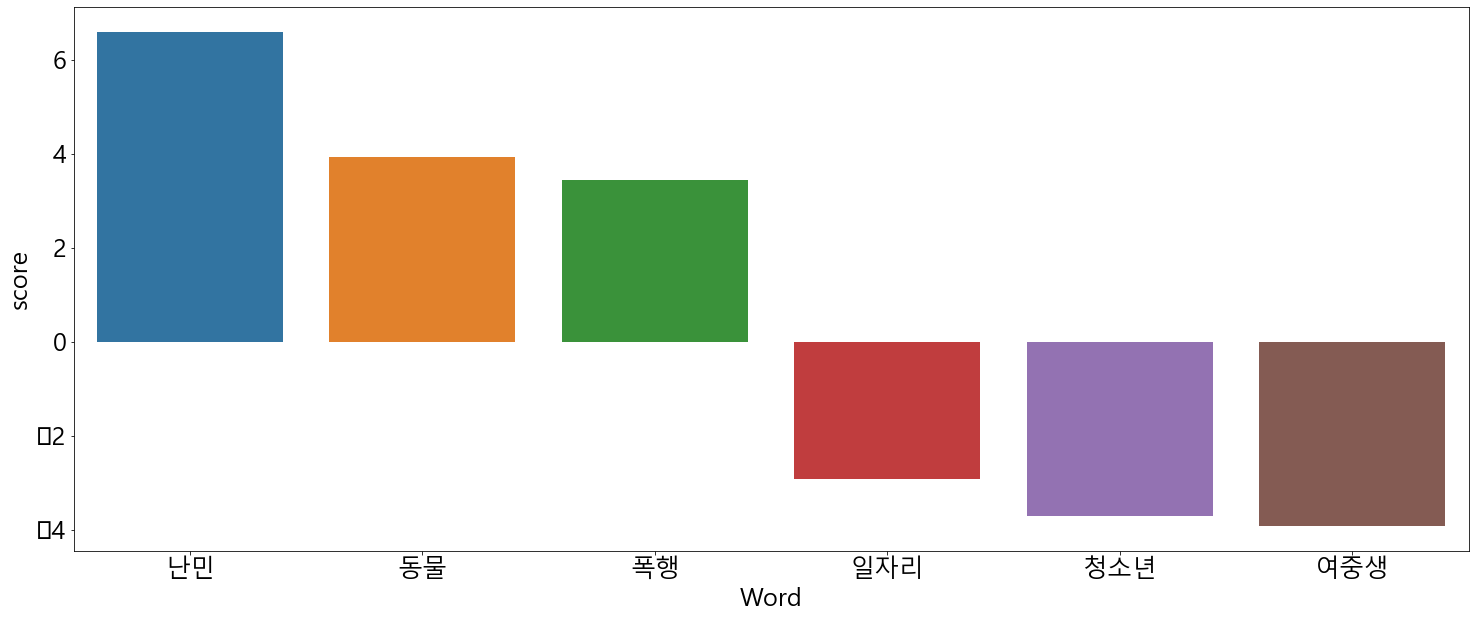

In [86]:
plt.rc('font', family='Malgun Gothic')
ax=sns.barplot(data = W_B_df_1, x = 'Word', y = "score")
ax.figure.set_size_inches(25, 10)
plt.rcParams['font.size'] = 25
plt.savefig("로지스틱회귀결과.png")